In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Model and Dataset
We load a pretrained VGG16 model and a test dataset.

In [2]:
from datasets import get_dataset 
from torchvision.models import vgg16

model = vgg16(weights="IMAGENET1K_V1")
model.eval()
model = model.cuda()

dataset_fn = get_dataset("imagenet_pexels")
dataset = dataset_fn(data_path="datasets/pexels", preprocessing=True, split="train")
dataset_fv = dataset_fn(data_path="datasets/pexels", preprocessing=False, split="train")

Loading imagenet_pexels


## Concept Attributions
We set up the computation of concept attributions. Here, the composite is for LRP with EpsilonPlusFlat-rule. The canonizer is specific to the VGG model.

In [3]:
from zennit.torchvision import VGGCanonizer
from utils.lrp_composites import EpsilonPlusFlat
from crp.attribution import CondAttribution

attribution = CondAttribution(model)
composite = EpsilonPlusFlat(canonizers=[VGGCanonizer()])

## Feature Visualization
We initialize the feature visualization class that will be used to visualize the concepts.

In [4]:
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from utils.crp import FeatVis

layer_names = get_layer_names(model, [torch.nn.Conv2d])
layer_map = {layer: ChannelConcept() for layer in layer_names}

fv = FeatVis(attribution, dataset_fv, layer_map, preprocess_fn=dataset.preprocessing, path=f"crp_files/vgg16_imagenet_pexels")
fv.run(composite, 0, len(dataset) // 1, batch_size=32) # needs to be run only once
print("CRP preprocessing done.")

Running Analysis...


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


100%|██████████| 26/26 [00:00<00:00, 957.49it/s]

CRP preprocessing done.


## Test sample
Let's look at a test sample and its LRP heatmap.

In [5]:
data = dataset_fv[-1][0]
attr = attribution(dataset.preprocessing(data).unsqueeze(0).cuda().requires_grad_(),
                   [{"y": 130}],
                   composite,
                   record_layer=layer_names)

print(f"prediction: class {attr.prediction.argmax().item()} with probability {attr.prediction.softmax(1).max().item():.2f}")

prediction: class 130 with probability 1.00


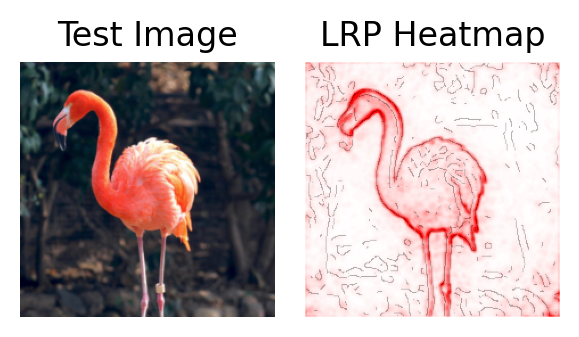

In [6]:
from skimage.feature import canny
from scipy.ndimage import filters, gaussian_filter
from crp.image import imgify

fig, axes = plt.subplots(1, 2, dpi=200, figsize=(3, 2), facecolor='white')
axes[0].imshow(data.permute(1, 2, 0))
axes[0].axis("off")
axes[0].set_title("Test Image")
heatmap = imgify(attr.heatmap[0], cmap="bwr", symmetric=True, level=2.0)

# compute edges for overlay
smooth = data.permute(1, 2, 0).mean(-1)
edges = abs(canny(smooth.numpy(), sigma=1.5, use_quantiles=True, low_threshold=0.7))
edges = gaussian_filter(edges * 1.0, 0.3)
edges = edges / edges.max()
edges[edges > 0.1] = 1

axes[1].imshow(heatmap, alpha=1.0)
axes[1].imshow(1 - edges, alpha=edges*0.3, cmap="gray")

axes[1].axis("off")
axes[1].set_title("LRP Heatmap")
plt.tight_layout()
plt.show()

In [7]:
layer_name = "features.28"
channel_rels = ChannelConcept().attribute(attr.relevances[layer_name], abs_norm=True) # sum attributions over spatial dimensions and normalize to 1

topk = torch.topk(channel_rels[0], k=5)
topk_ind = topk.indices.detach().cpu().numpy()
topk_rel = channel_rels[0, topk_ind]

print("Top 5 most relevant neurons:")
for neuron, rel in zip(topk_ind, 100 * topk_rel.detach().cpu().numpy()):
    print(f"neuron #{neuron} ({rel:.2f}% relevance)")

Top 5 most relevant neurons:
neuron #457 (6.51% relevance)
neuron #173 (5.10% relevance)
neuron #153 (3.39% relevance)
neuron #243 (3.09% relevance)
neuron #450 (2.60% relevance)


## Concept Localization with CRP
Let's compute neuron-specific heatmaps.

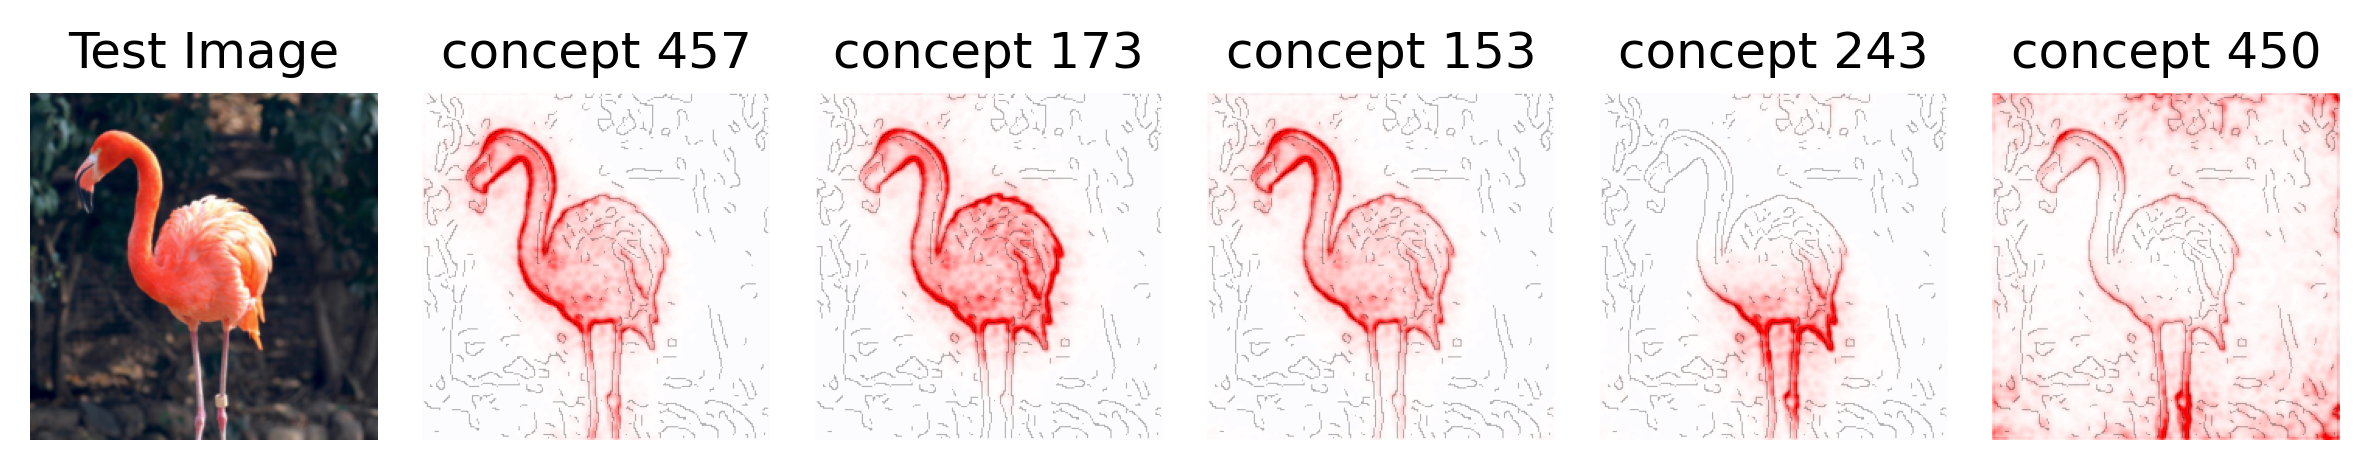

In [8]:
# conditional heatmaps
conditions = [{"y": 130, layer_name: c} for c in topk_ind]
cond_attr = attribution(dataset.preprocessing(data).unsqueeze(0).cuda().requires_grad_(), conditions, composite, record_layer=layer_names,)
cond_heatmap = cond_attr.heatmap

fig, axes = plt.subplots(1, 6, dpi=300, figsize=(8, 3), facecolor='white')
axes[0].imshow(data.permute(1, 2, 0))
axes[0].axis("off")
axes[0].set_title("Test Image")
for i, (ind, rel) in enumerate(zip(topk_ind, topk_rel)):
    axes[i + 1].imshow(imgify(cond_heatmap[i], symmetric=True, cmap="bwr", level=2.0))
    axes[i + 1].imshow(1 - edges, alpha=edges*0.3, cmap="gray")
    axes[i + 1].axis("off")
    axes[i + 1].set_title(f"concept {ind}")
    
plt.tight_layout()
plt.show()


## Concept Visualization with RelMax
We compute the top 12 reference images for each concept.

In [9]:
from utils.render import vis_opaque_img_border

n_refimgs = 12
n_concepts = 5
ref_imgs = fv.get_max_reference(topk_ind, layer_name, "relevance", (0, n_refimgs), composite=composite, rf=True,
                                plot_fn=vis_opaque_img_border, batch_size=12)

## Full Concept-based Explanation
We compute the full CRP explanation, where we learn how the flamingo is recognized by the model.
For example, the red color, the long legs and background blur are important for the model to recognize the flamingo.

<ipython-input-10-63d893039f1d>:36: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  [resize(torch.from_numpy(np.asarray(i)).permute((2, 0, 1))) for i in ref_imgs[topk_ind[r]]],


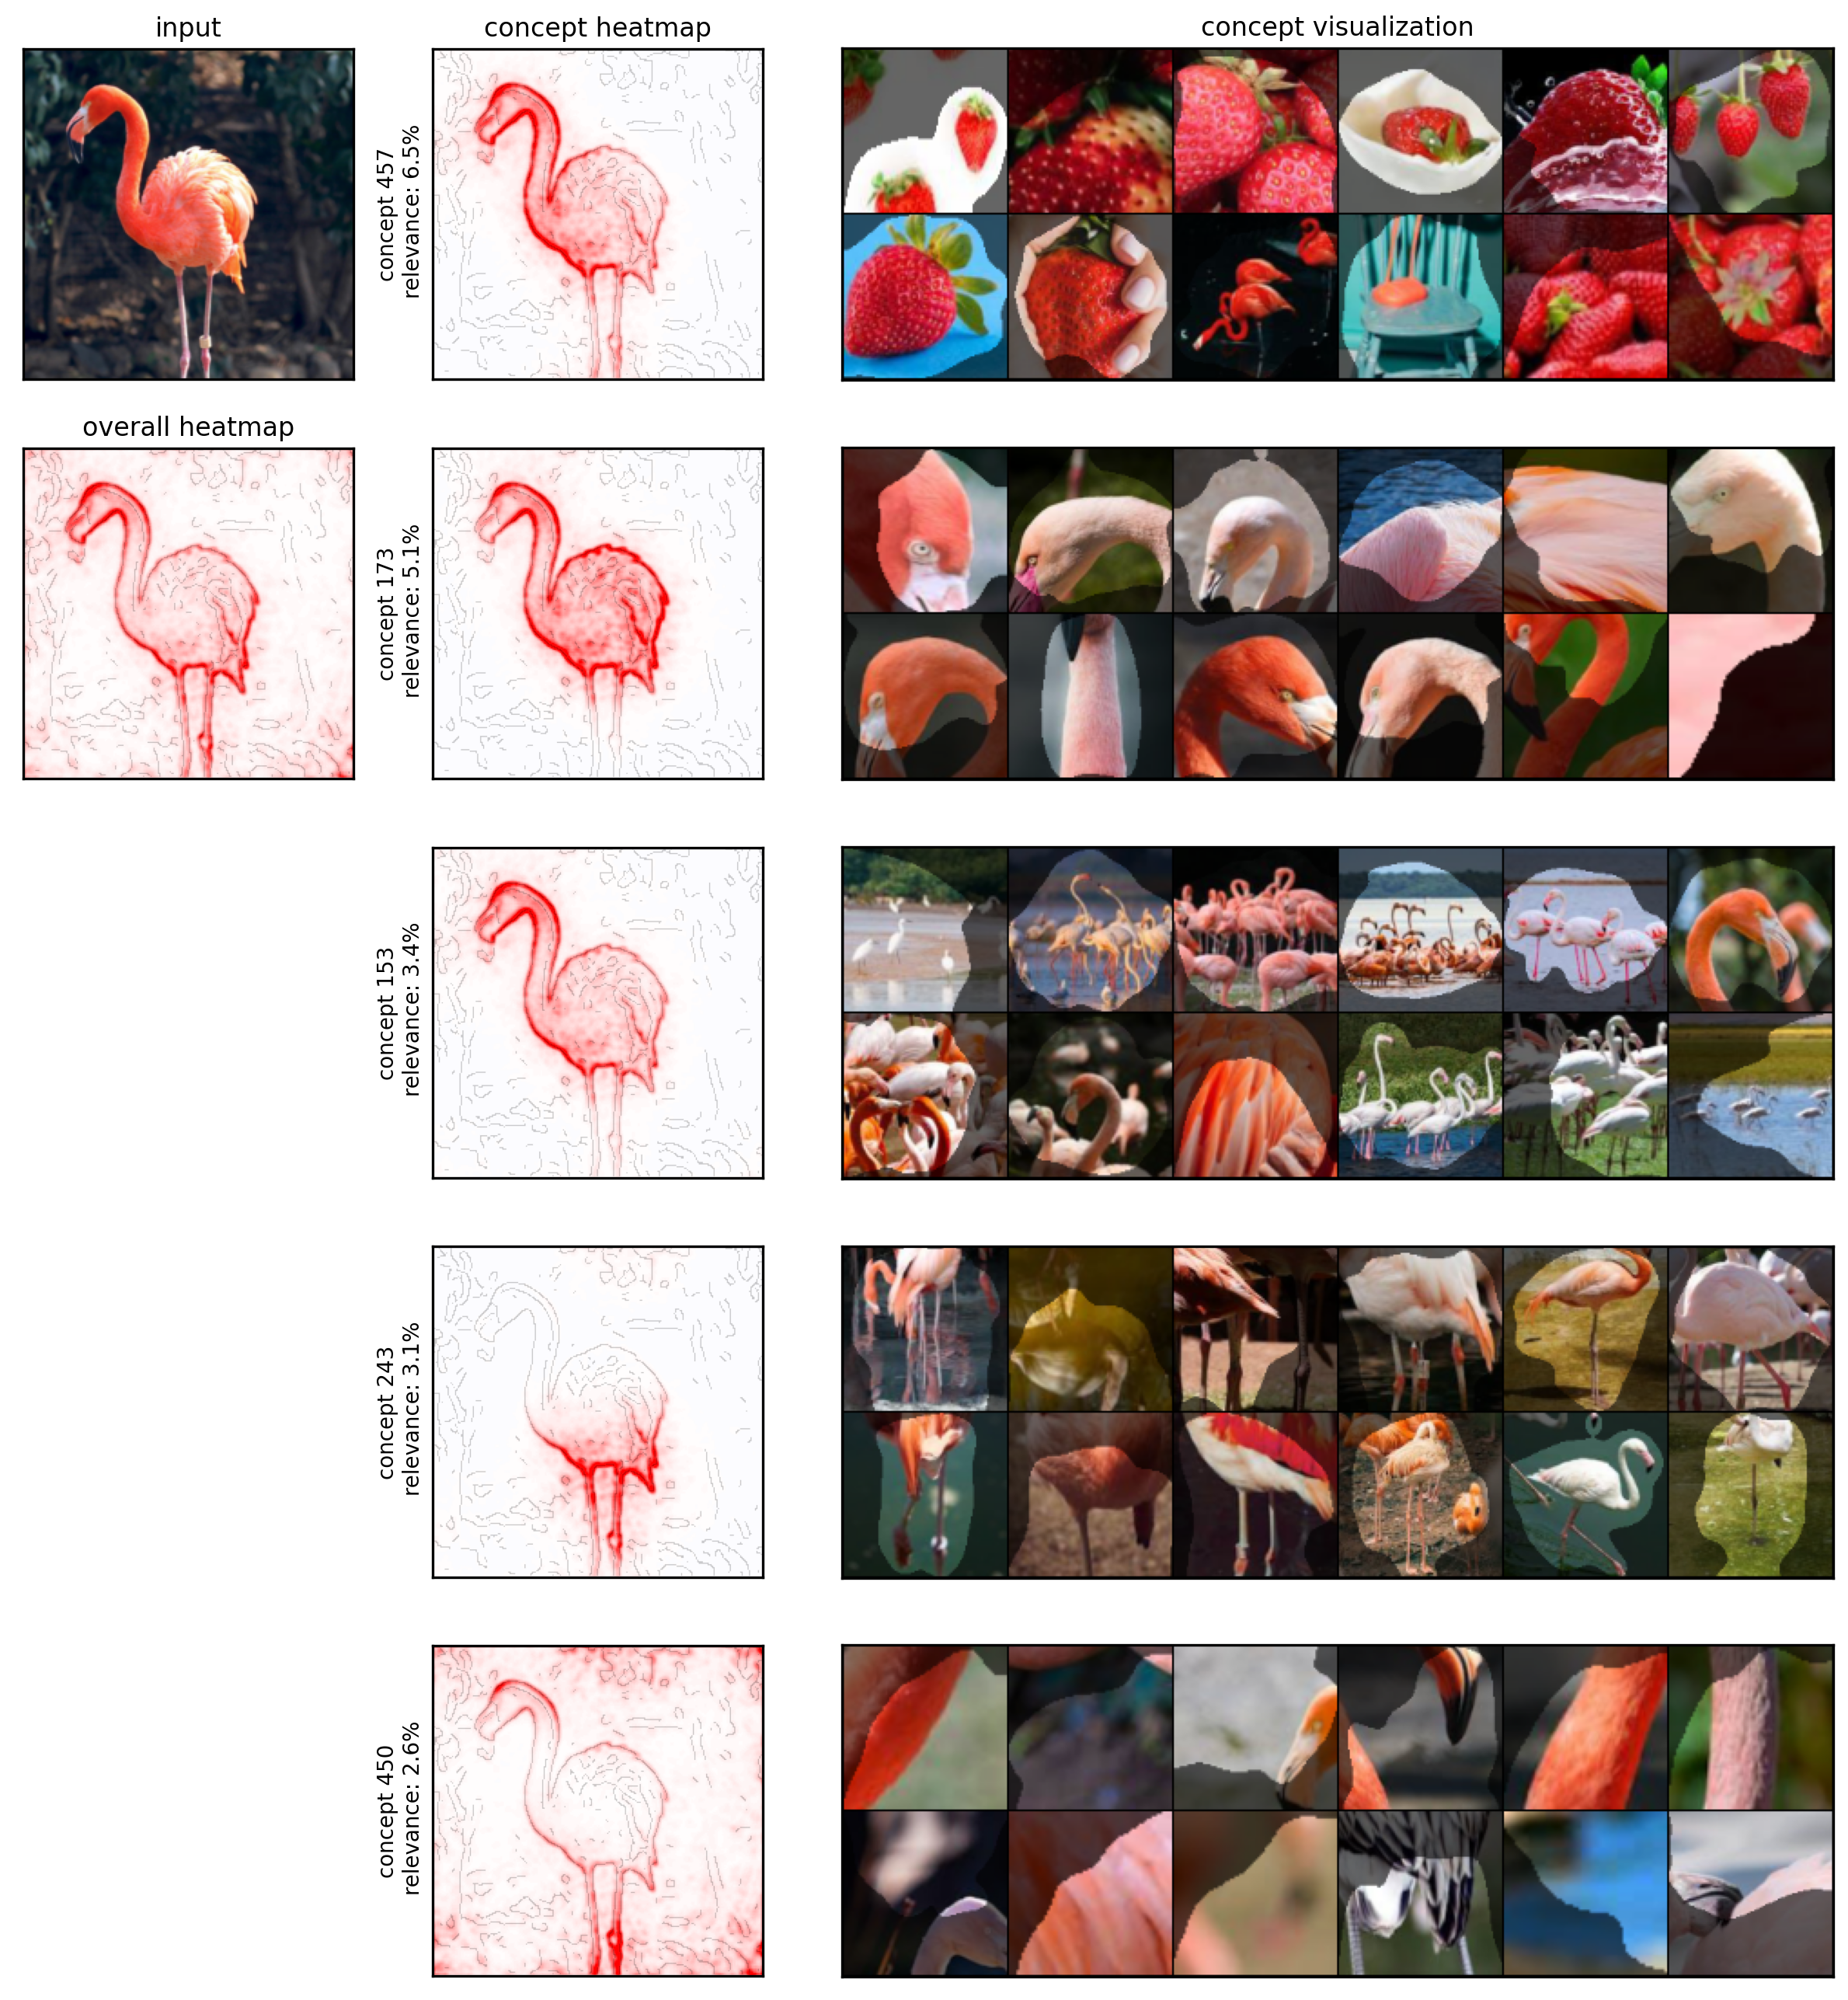

In [10]:
from torchvision.utils import make_grid
import torchvision


fig, axs = plt.subplots(n_concepts, 3, gridspec_kw={'width_ratios': [1, 1, n_refimgs / 4]},
                        figsize=(4 * n_refimgs / 4, 2.6 * n_concepts), dpi=200, facecolor='white')
resize = torchvision.transforms.Resize((90, 90))

for r, row_axs in enumerate(axs):
    for c, ax in enumerate(row_axs):
        
        if c == 0:
            
            if r == 0:
                ax.set_title("input")
                ax.imshow(imgify(data))
            elif r == 1:
                ax.set_title("overall heatmap")
                img = imgify(attr.heatmap, cmap="bwr", symmetric=True, level=2.0)
                ax.imshow(img)
                ax.imshow(1 - edges, alpha=edges*0.2, cmap="gray", vmin=0, vmax=1)
            else:
                ax.axis("off")

        if c == 1:
            if r == 0:
                ax.set_title("concept heatmap")
            ax.imshow(imgify(cond_heatmap[r], symmetric=True, cmap="bwr", level=2.0))
            ax.imshow(1 - edges, alpha=edges*0.2, cmap="gray", vmin=0, vmax=1)
            ax.set_ylabel(f"concept {topk_ind[r]}\n relevance: {(topk_rel[r] * 100):2.1f}%")

        elif c >= 2:
            if r == 0 and c == 2:
                ax.set_title("concept visualization")
            grid = make_grid(
                [resize(torch.from_numpy(np.asarray(i)).permute((2, 0, 1))) for i in ref_imgs[topk_ind[r]]],
                nrow=int(n_refimgs / 2), padding=1)
            ax.imshow(imgify(grid.detach().cpu()))
            ax.yaxis.set_label_position("right")
        
        [i.set_linewidth(1.2) for i in ax.spines.values()]
        ax.set_xticks([])
        ax.set_yticks([]) 
plt.tight_layout()
plt.show()